In [1]:
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pdb

In [2]:
from easydict import EasyDict as edict
from matplotlib import pyplot as plt
from torchvision import transforms as trans
from PIL import Image
from pathlib import Path
from models.yolo_body_res50 import Yolo_body
import numpy as np
# np.seterr(all='raise')
import torch
from torch import nn, optim
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
from utils.vis_utils import *
from utils.box_utils import *
from utils.dataset_tools import *
from utils.utils import *
from models.Yolo_head import Yolo_loss
from tensorboardX import SummaryWriter
from tqdm import tqdm_notebook as tqdm
from imgaug import augmenters as iaa
from Yolo_trainer import Yolo

In [3]:
conf = edict()

conf.coco_anchors = [[10, 13], [16, 30], [33, 23], [30, 61], [62, 45],
                     [59, 119], [116, 90], [156, 198], [373, 326]]
conf.train_path = Path('/home/f/nvme/coco2017/train2017/')
conf.train_anno_path = Path(
    '/home/f/nvme/coco2017/annotations/instances_train2017.json')
conf.val_path = Path('/home/f/nvme/coco2017/val2017/')
conf.val_anno_path = Path(
    '/home/f/nvme/coco2017/annotations/instances_val2017.json')
conf.log_path = Path('/home/f/learning/yolo/log')
conf.model_path = Path('/home/f/learning/yolo/model')
conf.save_path = Path('/home/f/learning/yolo/save')
conf.ids_path = 'data/ids.npy'

conf.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# train_dataset = datasets.CocoDetection(conf.train_path, conf.train_anno_path)
coco_class_2_id, coco_id_2_class = get_coco_class_name_map(
    conf.train_anno_path)
conf.class_num = len(coco_id_2_class)

id_2_correct_id = {}
correct_id_2_id = {}
id_2_correct_id = dict(zip(coco_id_2_class.keys(), range(80)))
correct_id_2_id = dict(zip(range(80), coco_id_2_class.keys()))

correct_id_2_class = {}
class_2_correct_id = {}
for k, v in coco_id_2_class.items():
    correct_id_2_class[id_2_correct_id[k]] = v
    class_2_correct_id[v] = id_2_correct_id[k]

# train_dataset.maps = [
#     id_2_correct_id, correct_id_2_id, correct_id_2_class, class_2_correct_id
# ]

id_2_correct_id = {}
correct_id_2_id = {}
id_2_correct_id = dict(zip(coco_id_2_class.keys(), range(80)))
correct_id_2_id = dict(zip(range(80), coco_id_2_class.keys()))

correct_id_2_class = {}
class_2_correct_id = {}
for k, v in coco_id_2_class.items():
    correct_id_2_class[id_2_correct_id[k]] = v
    class_2_correct_id[v] = id_2_correct_id[k]

# val_dataset = datasets.CocoDetection(conf.val_path, conf.val_anno_path)
# val_dataset.maps = [
#     id_2_correct_id, correct_id_2_id, correct_id_2_class, class_2_correct_id
# ]

maps = [
    id_2_correct_id, correct_id_2_id, correct_id_2_class, class_2_correct_id
]

loading annotations into memory...
Done (t=9.42s)
creating index...
index created!


In [90]:
conf.running_norm = 0.
# conf.gdclip = 3000.
conf.num_workers = 8
conf.batch_size = 16
conf.gdclip = None
conf.coord_scale = 2.
conf.noobject_scale = 0.5
conf.object_scale = 5
conf.class_scale = 5.
conf.thresh = 0.5
conf.evaluate_iou_threshold = 0.5
conf.predict_confidence_threshold = 0.5
conf.batch_size = 16
conf.input_size = [416, 416]
conf.mean = [0.5,0.5,0.5]
conf.std = [0.5,0.5,0.5]

conf.mse_loss = nn.MSELoss(size_average=False)
conf.bce_loss = nn.BCEWithLogitsLoss

conf.board_loss_every = 5
conf.evaluate_every = 5
conf.board_pred_image_every = 5
# conf.board_loss_every = len(train_loader) // 100
# conf.evaluate_every = len(train_loader) // 10
# conf.board_pred_image_every = len(train_loader) // 2
# conf.save_every = len(train_loader) // 2
# conf.board_grad_norm = len(train_loader) // 10

In [7]:
coco_ds = Coco_dataset(conf,conf.train_path,conf.train_anno_path,maps)

coco_loader = DataLoader(coco_ds,batch_size=conf.batch_size,shuffle=True,collate_fn=coco_collate_fn,pin_memory=True,num_workers=conf.num_workers)

loading annotations into memory...
Done (t=9.12s)
creating index...
index created!


In [93]:
imgs,bbox_group,labels_group = next(iter(coco_loader))

In [1]:
pair = namedtuple('pair', ['imgs', 'bboxes_group', 'labels_group'])

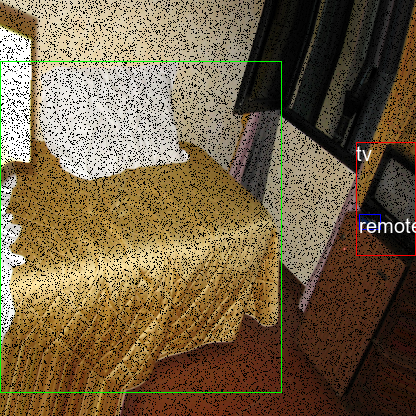

In [74]:
i = 0

draw_bbox_class(trans.ToPILImage()(de_preprocess(imgs[i],conf.mean,conf.std)),labels_group[i],bbox_group[i],correct_id_2_class)

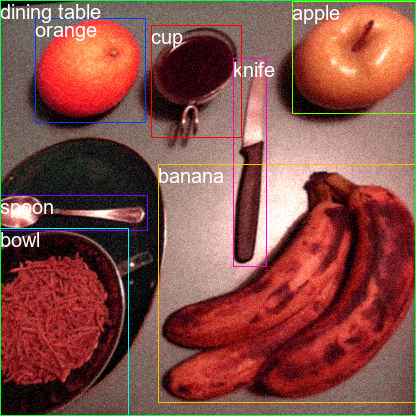

In [75]:
i = 1

draw_bbox_class(trans.ToPILImage()(de_preprocess(imgs[i],conf.mean,conf.std)),labels_group[i],bbox_group[i],correct_id_2_class)

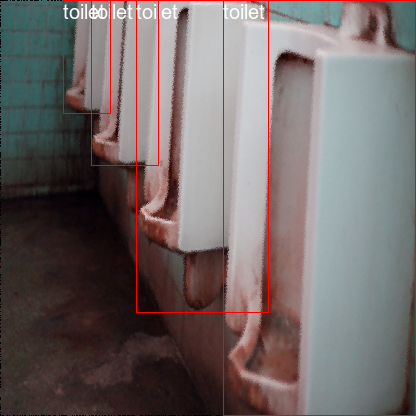

In [76]:
i = 2

draw_bbox_class(trans.ToPILImage()(de_preprocess(imgs[i],conf.mean,conf.std)),labels_group[i],bbox_group[i],correct_id_2_class)

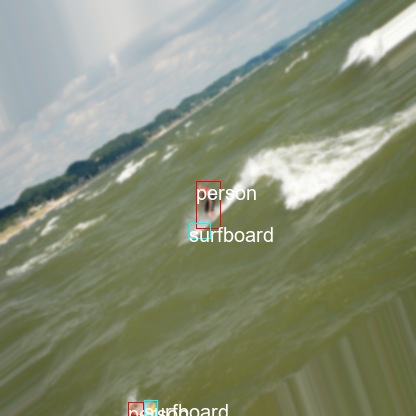

In [77]:
i = 3

draw_bbox_class(trans.ToPILImage()(de_preprocess(imgs[i],conf.mean,conf.std)),labels_group[i],bbox_group[i],correct_id_2_class)

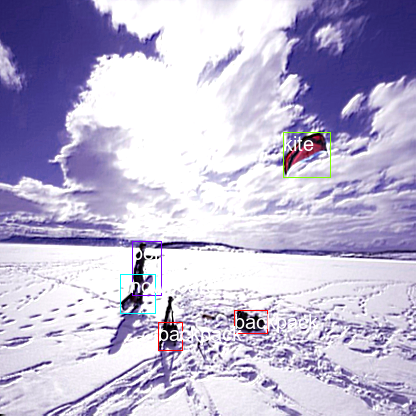

In [78]:
i = 4

draw_bbox_class(trans.ToPILImage()(de_preprocess(imgs[i],conf.mean,conf.std)),labels_group[i],bbox_group[i],correct_id_2_class)

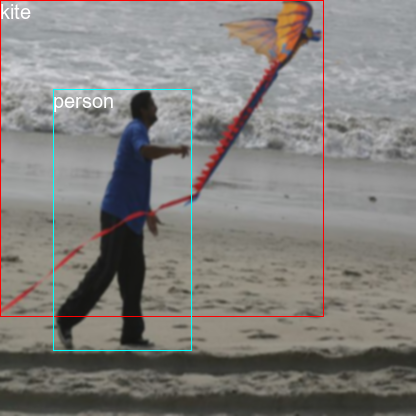

In [79]:
i = 5

draw_bbox_class(trans.ToPILImage()(de_preprocess(imgs[i],conf.mean,conf.std)),labels_group[i],bbox_group[i],correct_id_2_class)

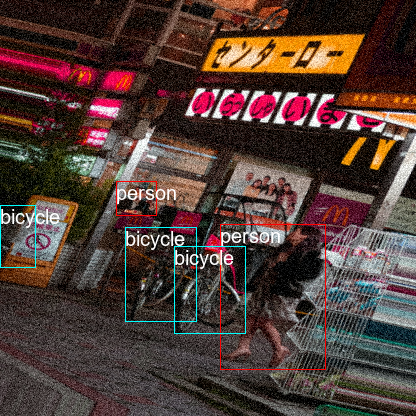

In [80]:
i = 6

draw_bbox_class(trans.ToPILImage()(de_preprocess(imgs[i],conf.mean,conf.std)),labels_group[i],bbox_group[i],correct_id_2_class)

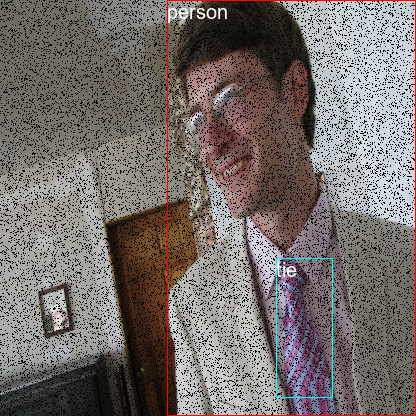

In [81]:
i = 7

draw_bbox_class(trans.ToPILImage()(de_preprocess(imgs[i],conf.mean,conf.std)),labels_group[i],bbox_group[i],correct_id_2_class)

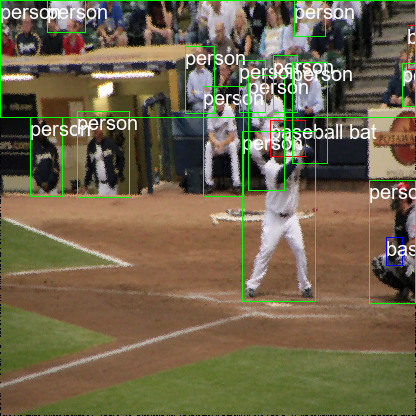

In [82]:
i = 8

draw_bbox_class(trans.ToPILImage()(de_preprocess(imgs[i],conf.mean,conf.std)),labels_group[i],bbox_group[i],correct_id_2_class)

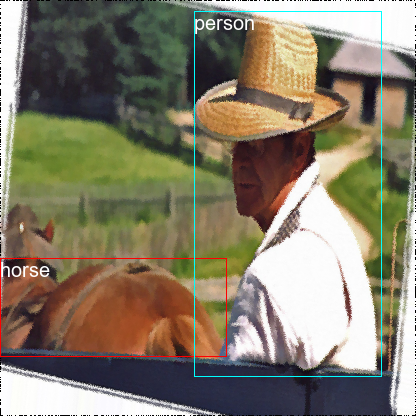

In [83]:
i = 9

draw_bbox_class(trans.ToPILImage()(de_preprocess(imgs[i],conf.mean,conf.std)),labels_group[i],bbox_group[i],correct_id_2_class)

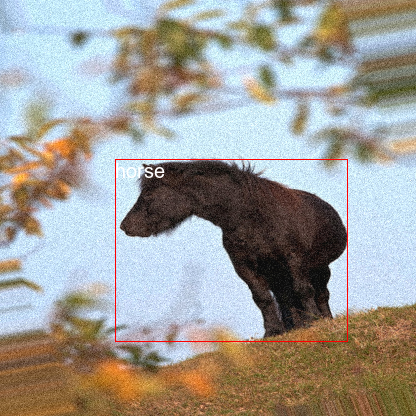

In [84]:
i = 10

draw_bbox_class(trans.ToPILImage()(de_preprocess(imgs[i],conf.mean,conf.std)),labels_group[i],bbox_group[i],correct_id_2_class)

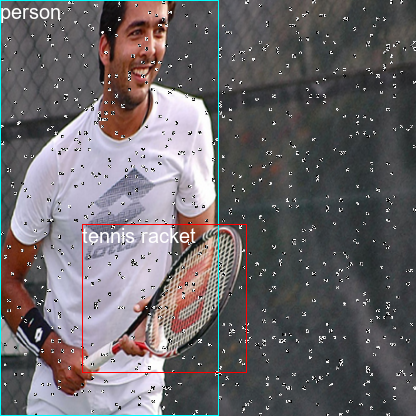

In [85]:
i = 11

draw_bbox_class(trans.ToPILImage()(de_preprocess(imgs[i],conf.mean,conf.std)),labels_group[i],bbox_group[i],correct_id_2_class)

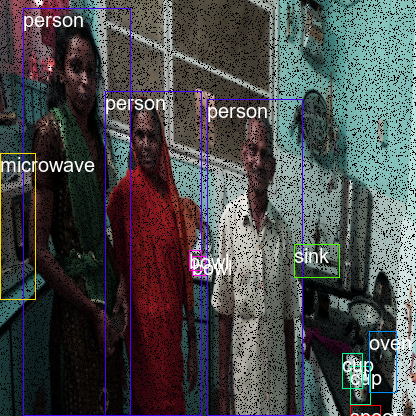

In [86]:
i = 12

draw_bbox_class(trans.ToPILImage()(de_preprocess(imgs[i],conf.mean,conf.std)),labels_group[i],bbox_group[i],correct_id_2_class)

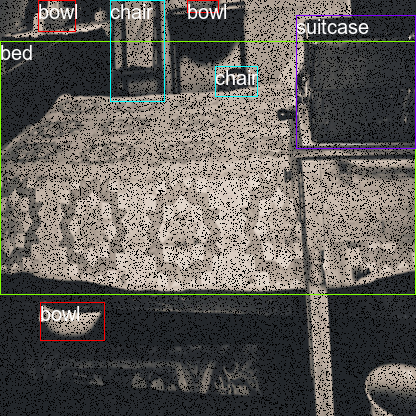

In [87]:
i = 13

draw_bbox_class(trans.ToPILImage()(de_preprocess(imgs[i],conf.mean,conf.std)),labels_group[i],bbox_group[i],correct_id_2_class)

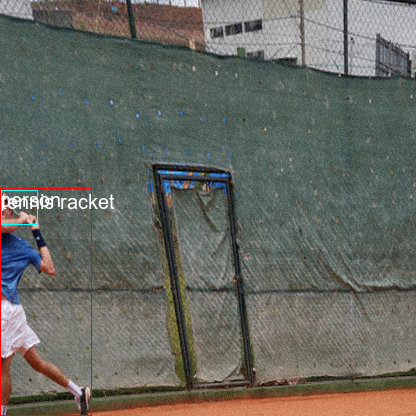

In [88]:
i = 14

draw_bbox_class(trans.ToPILImage()(de_preprocess(imgs[i],conf.mean,conf.std)),labels_group[i],bbox_group[i],correct_id_2_class)

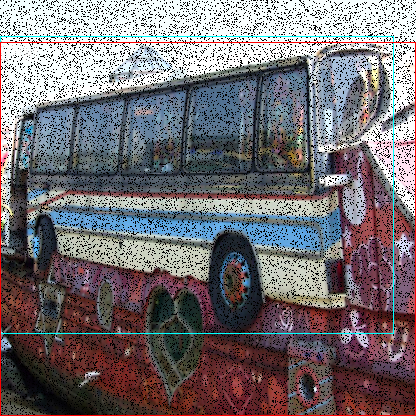

In [89]:
i = 15

draw_bbox_class(trans.ToPILImage()(de_preprocess(imgs[i],conf.mean,conf.std)),labels_group[i],bbox_group[i],correct_id_2_class)